Isotropic Total Variation (Accelerated PGM)
===========================================

This example demonstrates the use of class
[pgm.AcceleratedPGM](../_autosummary/scico.optimize.rst#scico.optimize.AcceleratedPGM)
to solve isotropic total variation (TV) regularization. It solves the
denoising problem

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - \mathbf{x}
  \|_2^2 + \lambda R(\mathbf{x}) + \iota_C(\mathbf{x}) \;,$$

where $R$ is a TV regularizer, $\iota_C(\cdot)$ is the indicator function
of constraint set $C$, and $C = \{ \mathbf{x} \, | \, x_i \in [0, 1] \}$,
i.e. the set of vectors with components constrained to be in the interval
$[0, 1]$. The problem is solved seperately with $R$ taken as isotropic
and anisotropic TV regularization

The solution via PGM is based on the approach in <cite data-cite="beck-2009-tv"/>,
which involves constructing a dual for the constrained denoising problem.
The PGM solution minimizes the resulting dual. In this case, switching
between the two regularizers corresponds to switching between two
different projectors.

In [1]:
from typing import Callable, Optional, Union

import jax
import jax.numpy as jnp

from xdesign import SiemensStar, discrete_phantom

import scico.numpy as snp
import scico.random
from scico import functional, linop, loss, operator, plot
from scico.array import ensure_on_device
from scico.blockarray import BlockArray
from scico.optimize.pgm import AcceleratedPGM, RobustLineSearchStepSize
from scico.typing import JaxArray
from scico.util import device_info
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
N = 256  # image size
phantom = SiemensStar(16)
x_gt = snp.pad(discrete_phantom(phantom, 240), 8)
x_gt = jax.device_put(x_gt)  # convert to jax type, push to GPU
x_gt = x_gt / x_gt.max()

Add noise to create a noisy test image.

In [3]:
σ = 0.75  # noise standard deviation
noise, key = scico.random.randn(x_gt.shape, seed=0)
y = x_gt + σ * noise

Define finite difference operator and adjoint.

In [4]:
# The append=0 option appends 0 to the input along the axis
# prior to performing the difference to make the results of
# horizontal and vertical finite differences the same shape
C = linop.FiniteDifference(input_shape=x_gt.shape, append=0)
A = C.adj

Define a zero array as initial estimate.

In [5]:
x0 = jnp.zeros(C(y).shape)

Define the dual of the total variation denoising problem.

In [6]:
class DualTVLoss(loss.Loss):
    def __init__(
        self,
        y: Union[JaxArray, BlockArray],
        A: Optional[Union[Callable, operator.Operator]] = None,
        lmbda: float = 0.5,
    ):
        y = ensure_on_device(y)
        self.functional = functional.SquaredL2Norm()
        super().__init__(y=y, A=A, scale=1.0)
        self.lmbda = lmbda

    def __call__(self, x: Union[JaxArray, BlockArray]) -> float:

        xint = self.y - self.lmbda * self.A(x)
        return -1.0 * self.functional(xint - jnp.clip(xint, 0.0, 1.0)) + self.functional(xint)

Denoise with isotropic total variation. Define projector for isotropic
total variation.

In [7]:
# Evaluation of functional set to zero.
class IsoProjector(functional.Functional):

    has_eval = True
    has_prox = True

    def __call__(self, x: Union[JaxArray, BlockArray]) -> float:
        return 0.0

    def prox(self, v: JaxArray, lam: float, **kwargs) -> JaxArray:
        norm_v_ptp = jnp.sqrt(jnp.sum(jnp.abs(v) ** 2, axis=0))

        x_out = v / jnp.maximum(jnp.ones(v.shape), norm_v_ptp)
        out1 = v[0, :, -1] / jnp.maximum(jnp.ones(v[0, :, -1].shape), jnp.abs(v[0, :, -1]))
        x_out_1 = jax.ops.index_update(x_out, jax.ops.index[0, :, -1], out1)
        out2 = v[1, -1, :] / jnp.maximum(jnp.ones(v[1, -1, :].shape), jnp.abs(v[1, -1, :]))
        x_out = jax.ops.index_update(x_out_1, jax.ops.index[1, -1, :], out2)

        return x_out

Use RobustLineSearchStepSize object and set up AcceleratedPGM solver
object. Run the solver.

In [8]:
reg_weight_iso = 1.4e0
f_iso = DualTVLoss(y=y, A=A, lmbda=reg_weight_iso)
g_iso = IsoProjector()

solver_iso = AcceleratedPGM(
    f=f_iso,
    g=g_iso,
    L0=16.0 * f_iso.lmbda ** 2,
    x0=x0,
    maxiter=100,
    itstat_options={"display": True, "period": 10},
    step_size=RobustLineSearchStepSize(),
)

# Run the solver.
print(f"Solving on {device_info()}\n")
x = solver_iso.solve()
hist_iso = solver_iso.itstat_object.history(transpose=True)
# Project to constraint set.
x_iso = jnp.clip(y - f_iso.lmbda * f_iso.A(x), 0.0, 1.0)

Solving on CPU



Iter  Time      Objective  L          Residual 
-----------------------------------------------
   0  1.48e+00  3.122e+04  2.822e+01  1.826e+01
  10  1.66e+00  1.915e+04  1.968e+01  7.745e+00


  20  1.84e+00  1.743e+04  2.745e+01  4.781e+00


  30  2.02e+00  1.703e+04  1.914e+01  3.830e+00


  40  2.23e+00  1.689e+04  2.670e+01  2.355e+00


  50  2.39e+00  1.683e+04  1.862e+01  2.238e+00


  60  2.57e+00  1.680e+04  2.597e+01  1.520e+00
  70  2.74e+00  1.678e+04  1.811e+01  1.541e+00


  80  2.96e+00  1.676e+04  2.526e+01  1.138e+00


  90  3.15e+00  1.675e+04  1.761e+01  1.218e+00


  99  3.35e+00  1.675e+04  2.729e+01  8.876e-01


Denoise with anisotropic total variation for comparison. Define
projector for anisotropic total variation.

In [9]:
# Evaluation of functional set to zero.
class AnisoProjector(functional.Functional):

    has_eval = True
    has_prox = True

    def __call__(self, x: Union[JaxArray, BlockArray]) -> float:
        return 0.0

    def prox(self, v: JaxArray, lam: float, **kwargs) -> JaxArray:

        return v / jnp.maximum(jnp.ones(v.shape), jnp.abs(v))

Use RobustLineSearchStepSize object and set up AcceleratedPGM solver
object. Weight was tuned to give the same data fidelty as the
isotropic case. Run the solver.

In [10]:
reg_weight_aniso = 1.2e0
f = DualTVLoss(y=y, A=A, lmbda=reg_weight_aniso)
g = AnisoProjector()

solver = AcceleratedPGM(
    f=f,
    g=g,
    L0=16.0 * f.lmbda ** 2,
    x0=x0,
    maxiter=100,
    itstat_options={"display": True, "period": 10},
    step_size=RobustLineSearchStepSize(),
)

# Run the solver.
x = solver.solve()
# Project to constraint set.
x_aniso = jnp.clip(y - f.lmbda * f.A(x), 0.0, 1.0)

Iter  Time      Objective  L          Residual 
-----------------------------------------------
   0  2.47e-01  3.122e+04  2.074e+01  2.130e+01
  10  4.20e-01  1.917e+04  1.446e+01  8.925e+00


  20  6.26e-01  1.748e+04  2.017e+01  5.680e+00


  30  7.93e-01  1.706e+04  1.406e+01  4.489e+00


  40  1.00e+00  1.692e+04  1.962e+01  2.742e+00


  50  1.17e+00  1.686e+04  1.368e+01  2.601e+00


  60  1.34e+00  1.683e+04  1.908e+01  1.758e+00


  70  1.53e+00  1.681e+04  1.330e+01  1.760e+00
  80  1.73e+00  1.680e+04  1.856e+01  1.290e+00


  90  1.90e+00  1.679e+04  1.294e+01  1.366e+00


  99  2.05e+00  1.678e+04  2.005e+01  9.858e-01


Compute the data fidelity.

In [11]:
df = hist_iso.Objective[-1]
print(f"Data fidelity for isotropic TV was {df:.2e}")
hist = solver.itstat_object.history(transpose=True)
df = hist.Objective[-1]
print(f"Data fidelity for anisotropic TV was {df:.2e}")

Data fidelity for isotropic TV was 1.67e+04
Data fidelity for anisotropic TV was 1.68e+04


Plot results.

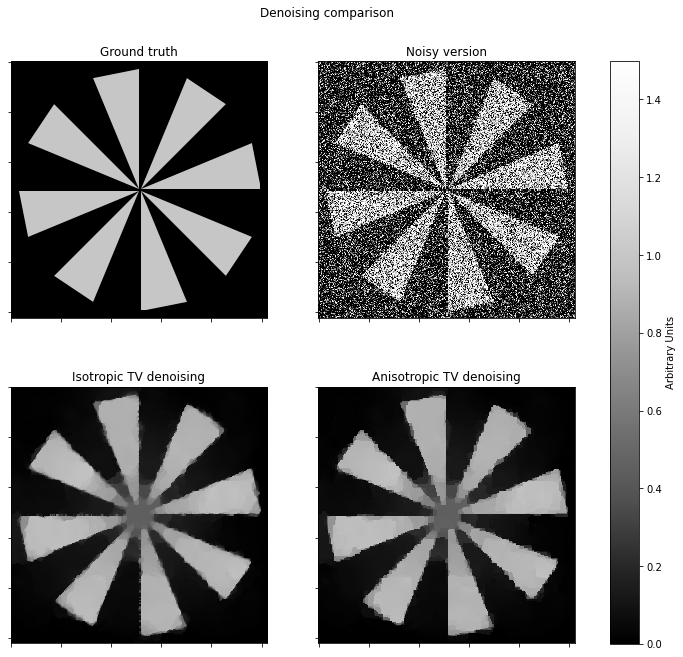

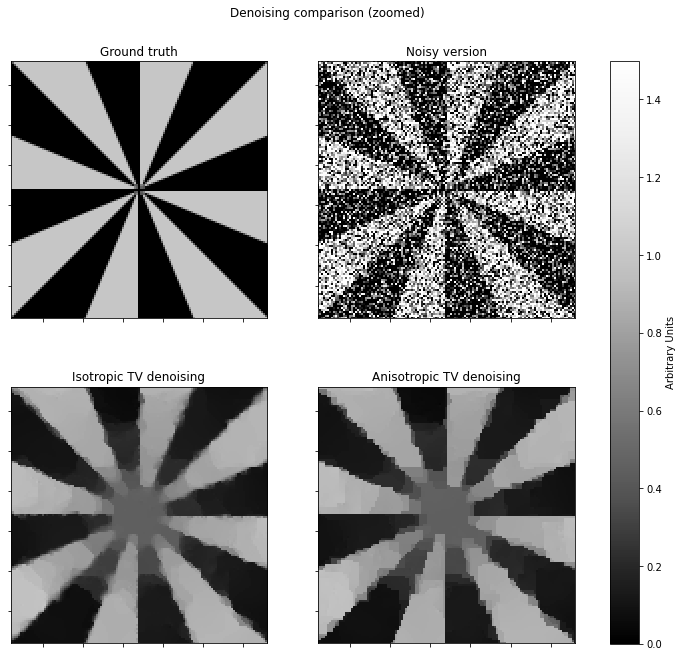

In [12]:
plt_args = dict(norm=plot.matplotlib.colors.Normalize(vmin=0, vmax=1.5))
fig, ax = plot.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(11, 10))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0, 0], **plt_args)
plot.imview(y, title="Noisy version", fig=fig, ax=ax[0, 1], **plt_args)
plot.imview(x_iso, title="Isotropic TV denoising", fig=fig, ax=ax[1, 0], **plt_args)
plot.imview(x_aniso, title="Anisotropic TV denoising", fig=fig, ax=ax[1, 1], **plt_args)
fig.subplots_adjust(left=0.1, right=0.99, top=0.95, bottom=0.05, wspace=0.2, hspace=0.01)
fig.colorbar(
    ax[0, 0].get_images()[0], ax=ax, location="right", shrink=0.9, pad=0.05, label="Arbitrary Units"
)
fig.suptitle("Denoising comparison")
fig.show()

# zoomed version
fig, ax = plot.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(11, 10))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0, 0], **plt_args)
plot.imview(y, title="Noisy version", fig=fig, ax=ax[0, 1], **plt_args)
plot.imview(x_iso, title="Isotropic TV denoising", fig=fig, ax=ax[1, 0], **plt_args)
plot.imview(x_aniso, title="Anisotropic TV denoising", fig=fig, ax=ax[1, 1], **plt_args)
ax[0, 0].set_xlim(N // 4, N // 4 + N // 2)
ax[0, 0].set_ylim(N // 4, N // 4 + N // 2)
fig.subplots_adjust(left=0.1, right=0.99, top=0.95, bottom=0.05, wspace=0.2, hspace=0.01)
fig.colorbar(
    ax[0, 0].get_images()[0], ax=ax, location="right", shrink=0.9, pad=0.05, label="Arbitrary Units"
)
fig.suptitle("Denoising comparison (zoomed)")
fig.show()